<div style="position: relative; text-align: center; background: #000; padding: 20px 10px; border-radius: 15px; box-shadow: 0 10px 25px rgba(0,0,0,0.7); font-family: 'Segoe UI', sans-serif; color: white;">

  <img src="https://i.postimg.cc/85wt4PLP/A-B.jpg" 
       alt="Title Image" 
       style="display: block; margin: 2px auto 5px auto; border-radius: 10px; box-shadow: 0 0 10px #666;">
  
  <span style="
  color: #B8860B;
  font-family: 'Times New Roman', Times, serif;
  font-weight: bold;
  padding-bottom: 2px;
">
  Samane Najarian
</span>

</div>

### 1. Define the Problem  
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.  

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.  
  
But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data.

Analyzing Game Metrics: A Threefold Exploration into Session Increase and Player Retention  

**Question 1: Has the average number of game sessions increased by 5 sessions?**

**Question 2: Has player retention increased by 2% after 1 day?**
  
**Question 3: Has player retention increased by 5% after 7 days?**

In [11]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import levene
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms
import statsmodels.api as sm
from scipy.stats import norm

/tmp/ipykernel_33/3254123156.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
df = pd.read_csv('/kaggle/input/ab-test-cookie-cats/cookie_cats.txt')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.shape

(90189, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
metadata_table = """

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Cookie Cats Dataset Metadata</title>
    <style>
        body {
            font-family: "Times New Roman", serif;
            margin: 20px;
            background-color: #f4f4f4;
        }
        .container {
            max-width: 800px;
            margin: auto;
            background: black;
            padding: 20px;
            border-radius: 10px;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
        }
        h1 {
            color: black;
            text-align: center;
        }
        img {
            width: 100%;
            border-radius: 10px;
        }
        table {
            width: 100%;
            border-collapse: collapse;
            margin-top: 20px;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 10px;
            text-align: center;
            font-size: 16px;
            font-family: "Times New Roman", serif;
        }
        th {
            background-color: gray;
            color: white;
            font-size: 18px;
            font-weight: bold;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Dataset Metadata</h1>
        <img src="/kaggle/input/cookie-cat/Gate.jpeg" alt="Cookie Cats Game Image">
        <p>
            The Cookie Cats dataset contains information about players of this popular mobile game. It includes user ID, game version, total rounds played, and player retention on the first and seventh day.
        </p>
        <table>
            <tr>
                <th>Feature</th>
                <th>Description</th>
            </tr>
            <tr>
                <td>userid</td>
                <td>Unique identifier for each player</td>
            </tr>
            <tr>
                <td>version</td>
                <td>The game version the player used (gate_30 or gate_40)</td>
            </tr>
            <tr>
                <td>sum_gamerounds</td>
                <td>Total number of rounds played by the player</td>
            </tr>
            <tr>
                <td>retention_1</td>
                <td>Whether the player returned to the game after one day (True/False)</td>
            </tr>
            <tr>
                <td>retention_7</td>
                <td>Whether the player returned to the game after seven days (True/False)</td>
            </tr>
        </table>
    </div>
</body>
</html>

"""

display(HTML(metadata_table))

Feature,Description
userid,Unique identifier for each player
version,The game version the player used (gate_30 or gate_40)
sum_gamerounds,Total number of rounds played by the player
retention_1,Whether the player returned to the game after one day (True/False)
retention_7,Whether the player returned to the game after seven days (True/False)


In [7]:
df.duplicated().sum()

0

In [8]:
df_new = df.set_index('userid')
df_new.head()

,version,sum_gamerounds,retention_1,retention_7
userid,,,,
116,gate_30,3,False,False
337,gate_30,38,True,False
377,gate_40,165,True,False
483,gate_40,1,False,False
488,gate_40,179,True,True


In [9]:
desc = df_new.describe(include=['float', 'int']).T  
skewness = df_new.select_dtypes(include=['float', 'int']).skew().to_frame(name="skewness")
kurtosis = df_new.select_dtypes(include=['float', 'int']).kurtosis().to_frame(name="kurtosis")

stats_df_new = pd.concat([desc, skewness, kurtosis], axis=1) 

stats_df_new = stats_df_new.iloc[0:, 1:]  

title = "Descriptive Statistics for Sum of Games (sum_gamerounds)"

html_table = f"""
    <div style="background-color:#f2f2f2; padding:10px; border-radius:8px; width:60%; margin:auto; font-family:Arial, sans-serif;">
        <h3 style="text-align:center; color:#333; font-size:20px;">{title}</h3>
    </div>
    <br>
    {stats_df_new.to_html(index=False)}
"""

display(HTML(html_table))

mean,std,min,25%,50%,75%,max,skewness,kurtosis
51.872457,195.050858,0.0,5.0,16.0,51.0,49854.0,185.436313,47130.369631


In [10]:
Q1 = df_new['sum_gamerounds'].quantile(0.25)
Q3 = df_new['sum_gamerounds'].quantile(0.75)
IQR= Q3 - Q1
lower_bound= Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = (df_new['sum_gamerounds'] < lower_bound) | (df_new['sum_gamerounds'] > upper_bound)
outliers_count = outliers.sum()
print(outliers_count)

10177


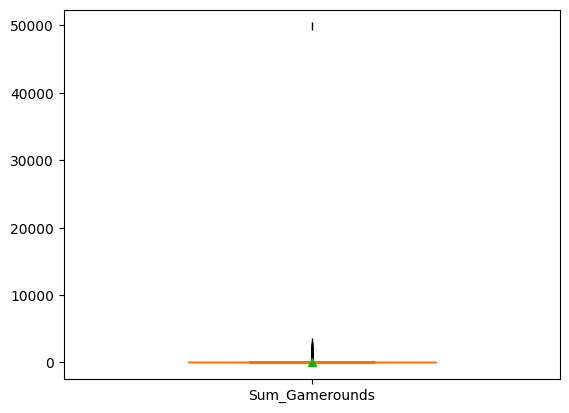

In [11]:
plt.boxplot(
    x=[df_new['sum_gamerounds']],         
    vert=True,                 
    patch_artist=True,          
    widths=0.5,                 
    sym='|',                   
    labels=['Sum_Gamerounds'],     
    showmeans=True,            
    showfliers=True,            

)

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


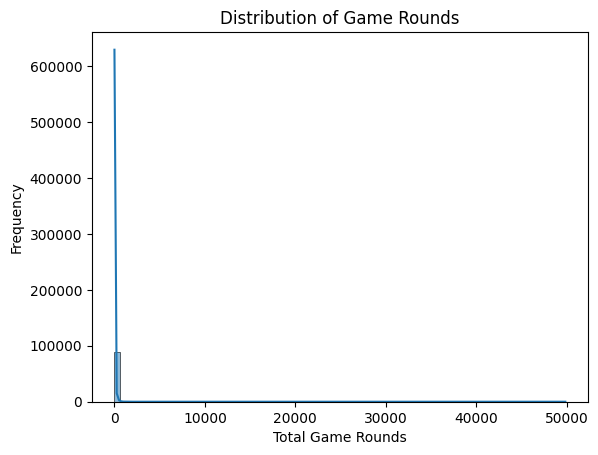

In [12]:
sns.histplot(df_new, x='sum_gamerounds', bins=80, kde=True)
plt.xlabel("Total Game Rounds")
plt.ylabel("Frequency")
plt.title("Distribution of Game Rounds")
plt.show()

In [13]:
def drop_outliers(df, columns, threshold=1.5):
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [15]:
df_WithoutOutliers = df_new.copy()
fig = make_subplots(
   rows=1, cols=8,
    specs=[[{}, {}, {}, {}, {}, {}, {}, {}]], subplot_titles=("Initial Data","Step1","Step2","Step3","Step4","Step5","Step6","Without Outliers"))
fig.add_trace(go.Box(y=df_WithoutOutliers['sum_gamerounds'],  name="Summation of Games ",marker_color='dodgerblue'), 1, 1)

df_WithoutOutliers = drop_outliers(df_WithoutOutliers,['sum_gamerounds'])       
fig.add_trace(go.Box(y=df_WithoutOutliers['sum_gamerounds'], name="Summation of Games",marker_color='deepskyblue'), 1, 2)

fig.update_layout(height=500, width=1300, showlegend=False, title_text="REMOVE OUTLIERS FROM sum_gamerounds", 
                  title_font = {"size": 14, "color": 'gray', 'family':'New Times Roman'}, title={ 'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show(renderer="iframe")

In [19]:
df_WithoutOutliers.head()

,version,sum_gamerounds,retention_1,retention_7
userid,,,,
116,gate_30,3,False,False
337,gate_30,38,True,False
483,gate_40,1,False,False
1066,gate_30,0,False,False
1444,gate_40,2,False,False


In [17]:
title_html = """
<h1 style="text-align:center; color:white; font-size:36px; font-family: 'Times New Roman', serif;">Has the average number of game sessions increased by 5 sessions?</h1>
"""

display(HTML(title_html))

In [20]:
alpha = 0.05
beta = 0.2
Z = (norm.ppf(1-(alpha/2), loc=0, scale=1) + norm.ppf(1-beta, loc=0, scale=1))**2
var = df_WithoutOutliers['sum_gamerounds'].var()
expected_effect_size = 5

sample_size = (Z*2*var)/(expected_effect_size**2)

print(sample_size.astype('int'))

474


In [17]:
def choose_random_sample(data):
    return data.sample(n=int(sample_size), random_state=123)

df_control_smpl = df_New.apply(choose_random_sample)
df_treatment_smpl = df_New.apply(choose_random_sample)
print("Control Dataset Sample")
print(df_control_smpl.head())
print("~"*60)
print("Treatment Dataset Sample")
print(df_treatment_smpl.head())

Control Dataset Sample
         version  sum_gamerounds  retention_1  retention_7
userid                                                    
4695679  gate_30               6        False        False
6724899  gate_30               2        False        False
6092570  gate_30               3        False        False
8245711  gate_30               3        False        False
9573485  gate_40              11        False        False
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Treatment Dataset Sample
         version  sum_gamerounds  retention_1  retention_7
userid                                                    
4695679  gate_30               6        False        False
6724899  gate_30               2        False        False
6092570  gate_30               3        False        False
8245711  gate_30               3        False        False
9573485  gate_40              11        False        False


In [37]:
df_control_smpl.shape

(102, 4)

In [18]:
Hypothesis="""

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Hypothesis Testing</title>
    <style>
        body {
            font-family: "Times New Roman", serif;
            margin: 14px;
        }
        h1 {
            color: white;
            text-align: center;
        }
        .hypothesis {
            margin-top: 20px;
            font-size: 14px;
        }
        .hypothesis h2 {
            color: white;
        }
        .hypothesis p {
            font-size: 14px;
        }
    </style>
</head>
<body>
    <h1>Hypothesis Testing</h1>
    <div class="hypothesis">
        <h5>H0:The mean number of game sessions for gate30(control group) =< The mean number of game sessions for gate40(treatment group)</h5>

        <h5>H1:The mean number of game sessions for gate30(control group) > The mean number of game sessions for gate40(treatment group)</h5>

        <h2>Decision Rule:If p-value < alpha => Reject the null hypothesis H0.</h2>
    
    </div>
</body>
</html>

"""


display(HTML(Hypothesis))

In [19]:
mean_control = df_control_smpl['sum_gamerounds'].mean()
mean_treatment = df_treatment_smpl['sum_gamerounds'].mean()

print("mean_control=", mean_control)
print("mean_treatment=",mean_treatment)

groupC = df_control_smpl['sum_gamerounds']
groupT = df_treatment_smpl['sum_gamerounds']
    
statistic, p_value_L = levene(groupC, groupT)

if  p_value_L > 0.05:

    t_statistic, p_value = ttest_ind(groupC, groupT,alternative="less" ,equal_var=True)

    print("t-statistic:", t_statistic)
    print("p-value:", p_value)

else:
        
    t_statistic, p_value = ttest_ind(groupC, groupT,alternative="less", equal_var=False)

    print("t-statistic:", t_statistic)
    print("p-value:", p_value)    
    
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")
print("\n")

mean_control= 14.156862745098039
mean_treatment= 14.156862745098039
t-statistic: 0.0
p-value: 0.5
Fail to reject the null hypothesis: There is no significant difference between the means.




In [20]:
title_html = """
<h1 style="text-align:center; color:white; font-size:36px; font-family: 'Times New Roman', serif;">Has player retention increased by 2% after 1 day?</h1>
"""

display(HTML(title_html))

In [21]:
cross_tab_retention1 = pd.crosstab(df_New['retention_1'],df_New['version'], normalize='index')
cross_tab_retention1

version,gate_30,gate_40
retention_1,,
False,0.494601,0.505399
True,0.505121,0.494879


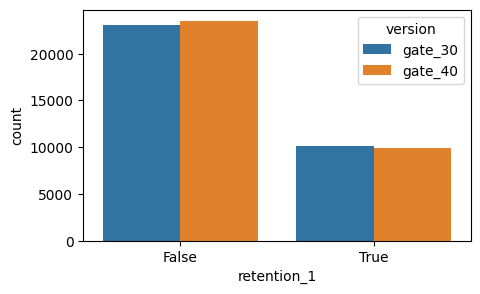

In [22]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.countplot(df_New, x='retention_1', hue='version', ax=ax)

plt.show()

In [23]:
alpha = 0.05       
power = 0.8        

p1 = 0.51      
p2 = 0.53      

es = sms.proportion_effectsize(p1,p2)
sample_size_retention1 = sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)

print(f"Required sample size for each group: {sample_size: .0f}")

Required sample size for each group:  102


In [24]:
def choose_random_sample1(data,random_state=123):
    return data.sample(n=int(sample_size_retention1), random_state=random_state)

df_smpl_retention1 = df_New.groupby('version', group_keys=False).apply(choose_random_sample)

print(df_smpl_retention1.head())

         version  sum_gamerounds  retention_1  retention_7
userid                                                    
361538   gate_30               2        False        False
6153263  gate_30              20         True        False
1131574  gate_30               0        False        False
8496863  gate_30               8        False        False
1115800  gate_30               2        False        False


/tmp/ipykernel_127/3670998056.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [25]:
Hypothesis="""

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Hypothesis Testing</title>
    <style>
        body {
            font-family: "Times New Roman", serif;
            margin: 14px;
        }
        h1 {
            color: white;
            text-align: center;
        }
        .hypothesis {
            margin-top: 20px;
            font-size: 14px;
        }
        .hypothesis h2 {
            color: white;
        }
        .hypothesis p {
            font-size: 14px;
        }
    </style>
</head>
<body>
    <h1>Hypothesis Testing</h1>
    <div class="hypothesis">
        <h5>H0:The proportion of players who return on day 1 is the same for Gate 30 (control group) and Gate 40 (treatment group)</h5>

        <h5>H1:The proportion of players who return on day 1 is not the same for Gate 30 (control group) and Gate 40 (treatment group).</h5>

        <h2>Decision Rule:If p-value < alpha => Reject the null hypothesis H0.</h2>
    
    </div>
</body>
</html>

"""


display(HTML(Hypothesis))

In [26]:
contingency_table_retention1 = pd.crosstab(df_smpl_retention1['retention_1'], df_smpl_retention1['version'])

print("Contingency Table with Frequencies:")
print(contingency_table_retention1)
print("#"*60)

row_percentages = contingency_table_retention1.div(contingency_table_retention1.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
print(row_percentages)
print("#"*60) 

success_A = contingency_table_retention1.iloc[1,1]
trials_A = contingency_table_retention1.iloc[1,0] + contingency_table_retention1.iloc[1,1]

success_B = contingency_table_retention1.iloc[0,1]
trials_B = contingency_table_retention1.iloc[0,0] + contingency_table_retention1.iloc[0,1]


z_stat, p_value = sm.stats.proportions_ztest([success_A, success_B], [trials_A, trials_B], alternative='smaller') 

print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in proportions.")
else:
    print("Fail to reject the null hypothesis. Proportions are not significantly different.")


Contingency Table with Frequencies:
version      gate_30  gate_40
retention_1                  
False             70       74
True              32       28
############################################################

Row Percentages:
version        gate_30    gate_40
retention_1                      
False        48.611111  51.388889
True         53.333333  46.666667
############################################################
Z-statistic: -0.6146362971528584
P-value: 0.2693974690088922
Fail to reject the null hypothesis. Proportions are not significantly different.


In [27]:
def OR_CIs(contingency_table):
    
    odds_ratio = (contingency_table.iloc[0, 0] / contingency_table.iloc[0, 1]) / (contingency_table.iloc[1, 0] / contingency_table_retention1.iloc[1, 1])

    log_odds_std_error = np.sqrt(contingency_table.applymap(lambda x: 1/x).sum().sum())

    confidence_level = 0.95

    z_score = norm.ppf(1-(1 - confidence_level) / 2)

    ci_low = np.exp(np.log(odds_ratio) - z_score * log_odds_std_error)
    ci_high = np.exp(np.log(odds_ratio) + z_score * log_odds_std_error)
    
    print(f"Odds Ratio: {odds_ratio:.2f}")
    print(f"95% Confidence Interval: {ci_low:.2f}, {ci_high:.2f}")
    
    return

In [28]:
OR_CIs(contingency_table_retention1)

Odds Ratio: 0.83
95% Confidence Interval: 0.45, 1.51


/tmp/ipykernel_127/431852303.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [29]:
title_html = """
<h1 style="text-align:center; color:white; font-size:36px; font-family: 'Times New Roman', serif;">Has player retention increased by 5% after 7 days?</h1>
"""

display(HTML(title_html))

In [30]:
cross_tab_retention7 = pd.crosstab(df_New['retention_7'],df_New['version'], normalize='index')
cross_tab_retention7

version,gate_30,gate_40
retention_7,,
False,0.495953,0.504047
True,0.525862,0.474138


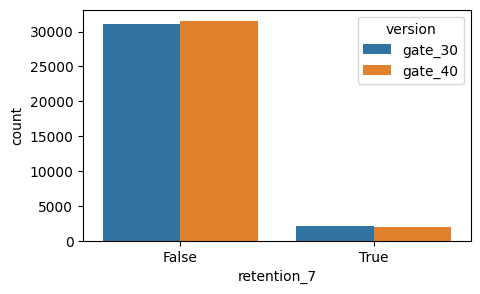

In [31]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.countplot(df_New, x='retention_7', hue='version', ax=ax)

plt.show()

In [32]:
alpha = 0.05       
power = 0.8        

p1 = 0.52      
p2 = 0.57      

es = sms.proportion_effectsize(p1,p2)
sample_size_retention7 = sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)

print(f"Required sample size for each group: {sample_size: .0f}")

Required sample size for each group:  102


In [33]:
def choose_random_sample7(data,random_state=123):
    return data.sample(n=int(sample_size_retention7), random_state=random_state)

df_smpl_retention7 = df_New.groupby('version', group_keys=False).apply(choose_random_sample7)

print(df_smpl_retention7.head())

         version  sum_gamerounds  retention_1  retention_7
userid                                                    
361538   gate_30               2        False        False
6153263  gate_30              20         True        False
1131574  gate_30               0        False        False
8496863  gate_30               8        False        False
1115800  gate_30               2        False        False


/tmp/ipykernel_127/2628456030.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [34]:
Hypothesis="""

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Hypothesis Testing</title>
    <style>
        body {
            font-family: "Times New Roman", serif;
            margin: 14px;
        }
        h1 {
            color: white;
            text-align: center;
        }
        .hypothesis {
            margin-top: 20px;
            font-size: 14px;
        }
        .hypothesis h2 {
            color: white;
        }
        .hypothesis p {
            font-size: 14px;
        }
    </style>
</head>
<body>
    <h1>Hypothesis Testing</h1>
    <div class="hypothesis">
        <h2>H0:The retention rate after 7 days has not increased by 5%.</h2>

        <h2>H1:The retention rate after 7 days has increased by at least 5%.</h2>

        <h2>Decision Rule:If p-value < alpha => Reject the null hypothesis H0.</h2>
    
    </div>
</body>
</html>

"""


display(HTML(Hypothesis))

In [35]:
contingency_table_retention7 = pd.crosstab(df_smpl_retention7['retention_7'], df_smpl_retention7['version'])

print("Contingency Table with Frequencies:")
print(contingency_table_retention7)
print("#"*60)

row_percentages_retention7 = contingency_table_retention7.div(contingency_table_retention7.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
print(row_percentages_retention7)
print("#"*60) 

success_A7 = contingency_table_retention7.iloc[1,1]
trials_A7 = contingency_table_retention7.iloc[1,0] + contingency_table_retention7.iloc[1,1]

success_B7 = contingency_table_retention7.iloc[0,1]
trials_B7 = contingency_table_retention7.iloc[0,0] + contingency_table_retention7.iloc[0,1]


z_stat7, p_value7 = sm.stats.proportions_ztest([success_A7, success_B7], [trials_A7, trials_B7], alternative='smaller') 

print(f"Z-statistic: {z_stat7}")
print(f"P-value: {p_value7}")

alpha = 0.05
if p_value7 < alpha:
    print("Reject the null hypothesis. There is a significant difference in proportions.")
else:
    print("Fail to reject the null hypothesis. Proportions are not significantly different.")

Contingency Table with Frequencies:
version      gate_30  gate_40
retention_7                  
False           1452     1467
True             103       88
############################################################

Row Percentages:
version        gate_30    gate_40
retention_7                      
False        49.743063  50.256937
True         53.926702  46.073298
############################################################
Z-statistic: -1.1203087357480066
P-value: 0.1312911103532513
Fail to reject the null hypothesis. Proportions are not significantly different.


In [36]:
OR_CIs(contingency_table_retention7)

Odds Ratio: 0.27
95% Confidence Interval: 0.20, 0.36


/tmp/ipykernel_127/431852303.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

